In [1]:
from resources.ml_mlp import MLP_Model
from resources.ml_mlp import Linear_Model
from resources.ml_mlp import MLP_Win_Model
from resources.ml_mlp import LSTM_Model
import resources
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import multiprocessing
multiprocessing.set_start_method("spawn")

2023-04-24 15:47:53.675842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 15:47:53.788330: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 15:47:54.321651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tomje/miniconda3/pkgs/cudatoolkit-11.8.0-h37601d7_11/lib/libcudart.so.11.0:/home

In [2]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
})
%matplotlib inline

## Pre-process data 
Load in feature datasets, remove wear in phase and combine.

In [3]:
exp5 = resources.load('Test 5')
exp7 = resources.load('Test 7')
exp8 = resources.load('Test 8')

exp9 = resources.load('Test 9')

In [4]:
dfs = [exp5.features.drop([23, 24]), exp7.features, exp8.features, exp9.features]

In [5]:
dfs = [df.drop([0, 1, 2, 3]) for df in dfs]

In [6]:
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff'])#.drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 692 rows x 8 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius
0,2.114221,7.972116,22.575564,-0.037290,46.668332,75.681806,42.884298,0.673830
1,2.231453,7.937418,20.322581,-0.030997,47.223830,76.327769,43.081297,0.672418
2,2.218086,8.176863,21.918605,-0.013387,47.121927,76.566675,42.880229,0.672192
3,2.288784,7.950098,19.731200,-0.023563,47.644655,76.725483,43.181153,0.672081
4,2.297028,8.107973,22.351243,-0.014962,47.152297,76.585970,43.056571,0.671812


In [7]:
def pred_plot(y: np.ndarray, y_pred: np.ndarray, title:str = ''):
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    ax1.scatter(y, y_pred)

    # limits of max radius
    # xmax = main_df['Mean radius'].values.max()
    # xmin = main_df['Mean radius'].values.min()
    xmax = 0.68
    xmin = 0.6
    

    ax1.set_xlim([xmin, xmax])
    ax1.set_ylim([xmin, xmax])

    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),
        np.max([ax1.get_xlim(), ax1.get_ylim()]),
    ]
    ax1.set_axisbelow(True)
    ax1.grid()
    ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax1.set_aspect('equal')
    ax1.set_xlabel('Actual Y (mm)')
    ax1.set_ylabel('Predicted Y (mm)')
    ax1.set_title(f'{title} - Predictions');
     
    diff = (y - y_pred)*1000

    ax2.hist(diff, bins=30)
    ax2.set_xlabel('Prediction Error / um')
    ax2.set_ylabel('No Occurances')
    ax2.set_title(f'{title} - Histogram');

    fig1.tight_layout()
    fig2.tight_layout()


## MLP

In [22]:
mlp_reg = MLP_Model(feature_df=main_df,
                    target='Mean radius',
                    tb=False,
                    tb_logdir='tmux-test',
                    params={'loss': 'mse',
                            'no_layers': 3,
                            'no_nodes': 128,
                            'epochs': 2000,
                            'dropout': 0.01,
                            'batch_size': 20,
                            'init_mode': 'glorot_uniform',
                            },
                    random_state=11,
                    )

In [23]:
# mlp_reg.cv(n_splits=10, n_repeats=10)
mlp_reg.fit(validation_split=0.1, verbose=0)
mlp_reg.score(plot_fig=False);

-----------------------------------------------------------------
MLP-E-2000-B-20-L[128 128 128]-D-0.01-20230424-164140


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.711 um
MSE = 1.894 um^2
R^2 = 0.986


In [10]:
# y = mlp_reg.val_data[1].values
# y_pred = mlp_reg.model.predict(mlp_reg.val_data[0].values, verbose=0)
# pred_plot(y, y_pred, 'MLP')

## MLP with Window

In [24]:
mlp_win_reg = MLP_Win_Model(feature_df=main_df,
                            target='Mean radius',
                            tb=False,
                            tb_logdir='tmux-test',
                            params={'seq_len': 5,
                                    'loss': 'mse',
                                    'epochs': 2000,
                                    'no_nodes': 128,
                                    'no_layers': 3,
                                    'batch_size': 20,
                                    'init_mode': 'glorot_uniform',
                                    'dropout': 0.01,
                                    },
                            random_state=11,
                            )

In [25]:
# mlp_win_reg.cv(n_splits=10, n_repeats=10)
mlp_win_reg.fit(validation_split=0.2, verbose=0)
mlp_win_reg.score(plot_fig=False);

-----------------------------------------------------------------
MLP_Win-WLEN-5-E-2000-B-20-L-[128 128 128]-D-0.01-20230424-164428


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.699 um
MSE = 5.237 um^2
R^2 = 0.960


In [13]:
# y = mlp_win_reg.val_data[1]
# y_pred = mlp_win_reg.model.predict(mlp_win_reg.val_data[0], verbose=0)
# pred_plot(y, y_pred, 'MLP_WIN')

## LSTM

In [14]:
lstm_reg = LSTM_Model(feature_df=main_df,
                      target='Mean radius',
                      tb=False,
                      tb_logdir='testing',
                      params={'seq_len': 15,
                              'loss': 'mse',
                              'epochs': 2000,
                              'no_layers': 3,
                              'no_dense': 1,
                              'no_nodes': 128,
                              'batch_size': 10,
                              'init_mode': 'glorot_uniform',
                              'dropout': 0.01,
                              },
                      random_state=11,
                      shuffle=True,
                      )

In [15]:
# lstm_reg.cv(n_splits=10, n_repeats=10)
lstm_reg.fit(validation_split=0.2, verbose=0)
lstm_reg.score(plot_fig=False);

-----------------------------------------------------------------
LSTM-WLEN-15-E-2000-B-10-L-[128 128 128 128]-D-0.01-20230424-155325


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.441 um
MSE = 0.559 um^2
R^2 = 0.996


In [16]:
# y = lstm_reg.val_data[1]
# y_pred = lstm_reg.model.predict(lstm_reg.val_data[0], verbose=0)
# pred_plot(y, y_pred, 'LSTM')

## Linear Model

In [17]:
# lin_reg = Linear_Model(feature_df=main_df, target='Mean radius')

In [18]:
# lin_reg.fit()
# lin_reg.score(plot_fig=False);

In [19]:
# y = lin_reg.val_data[1].values
# y_pred = lin_reg.model.predict(lin_reg.val_data[0].values)
# pred_plot(y, y_pred, 'Linear')

## Figures for Journal

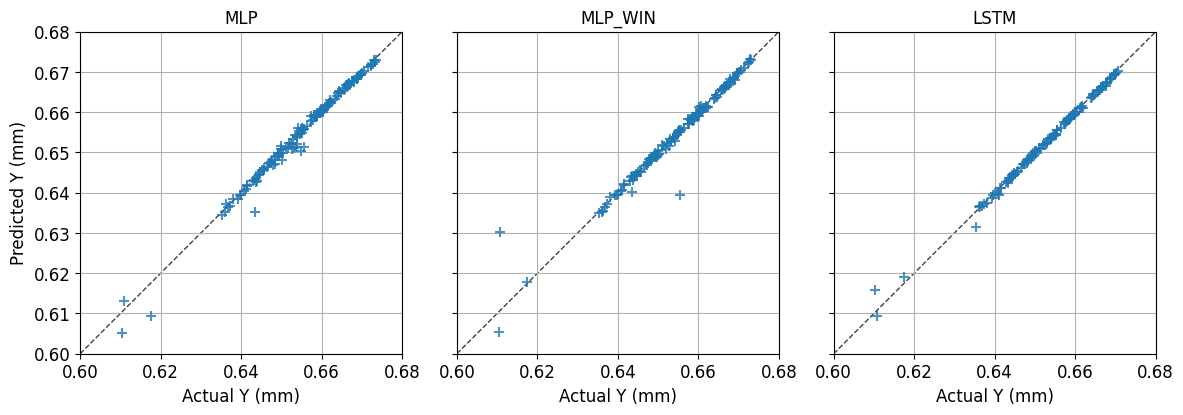

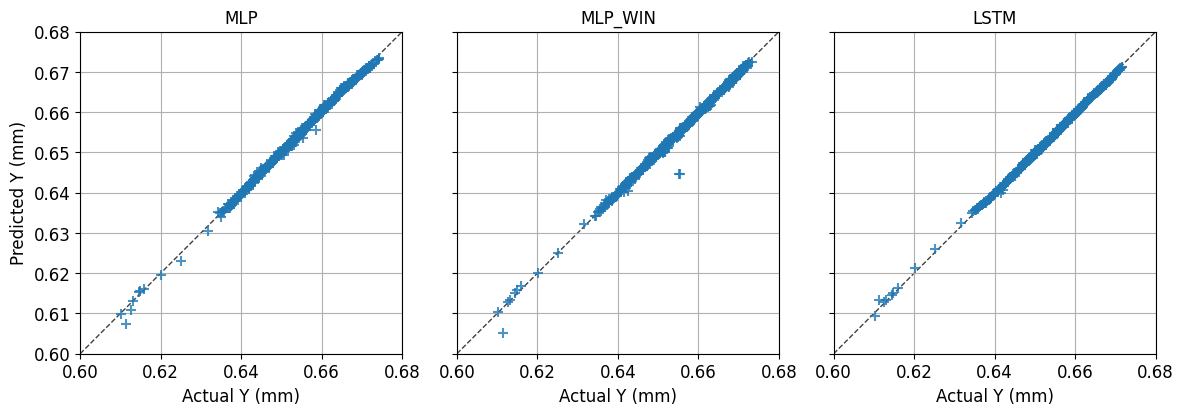

In [26]:
def pred_real_plot(y, y_pred, ax):
    ax.scatter(y, y_pred, marker='+', alpha=0.8, s=50)

    xmax = 0.68
    xmin = 0.6

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([xmin, xmax])

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.set_axisbelow(True)
    ax.grid()
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=1)
    ax.set_aspect('equal')
    return ax


models = {'MLP': mlp_reg, 
          'MLP_WIN': mlp_win_reg, 
          'LSTM': lstm_reg
          }

y = {name: mod.val_data[1] for name, mod in models.items()}
y_pred = {name: mod.model.predict(mod.val_data[0], verbose=0) for name, mod in models.items()}

fig, ax = plt.subplots(1, len(models), figsize=(12, 5), sharey=True, dpi = 100)
ax = ax.ravel()
for i, m in enumerate(models):
    ax[i] = pred_real_plot(y[str(m)], y_pred[str(m)], ax[i])
    ax[i].set_title(str(m), fontsize=12)
    ax[i].set_xlabel('Actual Y (mm)', fontsize=12)
ax[0].set_ylabel('Predicted Y (mm)', fontsize=12)
fig.tight_layout()

y = {name: mod.train_data[1] for name, mod in models.items()}
y_pred = {name: mod.model.predict(mod.train_data[0], verbose=0) for name, mod in models.items()}

fig, ax = plt.subplots(1, len(models), figsize=(12, 5), sharey=True, dpi = 100)
ax = ax.ravel()
for i, m in enumerate(models):
    ax[i] = pred_real_plot(y[str(m)], y_pred[str(m)], ax[i])
    ax[i].set_title(str(m), fontsize=12)
    ax[i].set_xlabel('Actual Y (mm)', fontsize=12)
ax[0].set_ylabel('Predicted Y (mm)', fontsize=12)
fig.tight_layout()

#### Show prediction of entire wear cycle

<AxesSubplot: >

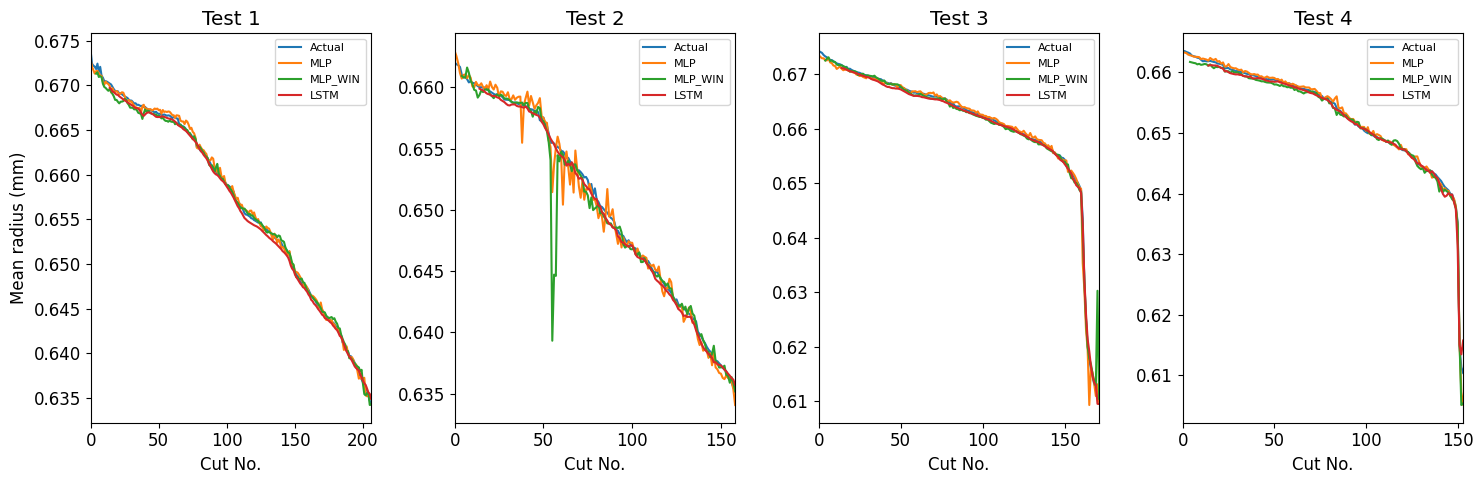

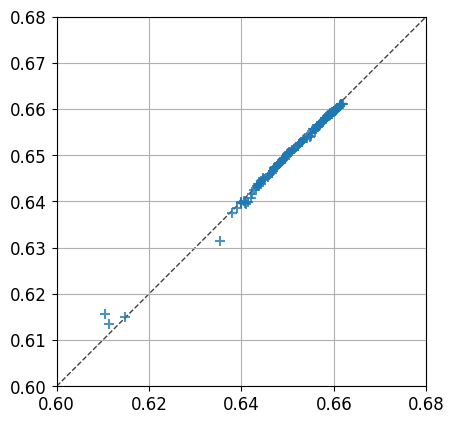

In [27]:
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def sequence_data(d: np.ndarray, mod):
    seq_data = []
    seq_len = mod.seq_len
    prev_points = deque(maxlen=seq_len)

    for i in d:
        prev_points.append([n for n in i])
        if len(prev_points) == seq_len:
            seq_data.append([np.array(prev_points)])
    return seq_data


dfs = [exp5.features.drop([23, 24]), exp7.features, exp8.features, exp9.features]

fig, ax = plt.subplots(1, len(dfs), figsize=(15, 5), dpi = 100)
ax = ax.ravel()

for i, df in enumerate(dfs):

    df = df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff']).drop([0, 1, 2, 3])
    df.reset_index(drop=True, inplace=True)
    df.head()

    mods = {'MLP': mlp_reg,
            'MLP_WIN': mlp_win_reg,
            'LSTM': lstm_reg,
            }

    x = df.drop(columns=['Mean radius']).to_numpy()
    y = df['Mean radius'].to_numpy()

    x_mlp = mods['MLP'].scaler.transform(x)

    x_mlp_win = sequence_data(mods['MLP_WIN'].scaler.transform(x), mods['MLP_WIN'])
    x_mlp_win = np.asarray(x_mlp_win).reshape(len(x_mlp_win), mods['MLP_WIN']._no_features)

    x_lstm = sequence_data(mods['LSTM'].scaler.transform(x), mods['LSTM'])
    x_lstm = np.asarray(x_lstm).squeeze()

    y_pred_mlp = mods['MLP'].model.predict(x_mlp, verbose=0)
    y_pred_mlp_win = mods['MLP_WIN'].model.predict(x_mlp_win, verbose=0)
    y_pred_lstm = mods['LSTM'].model.predict(x_lstm, verbose=0)

    # print(f'Test {i + 1}')
    # print('-' * 65)
    # print('\tMLP')
    # mods['MLP'].score(X=x_mlp, y=y, plot_fig=False)
    # print('-' * 65)
    # print('\tMLP_WIN')
    # mods['MLP_WIN'].score(X=x_mlp_win, y=y[-len(x_mlp_win):], plot_fig=False)
    # print('-' * 65)
    # print('\tLSTM')
    # mods['LSTM'].score(X=x_lstm, y=y[-len(x_lstm):], plot_fig=False)
    # print('\n')

    mlp_win_slen = mods['MLP_WIN'].seq_len
    lstm_slen = mods['LSTM'].seq_len

    ax[i].plot(y, label='Actual')
    ax[i].plot(y_pred_mlp, label='MLP')
    ax[i].plot(np.insert(y_pred_mlp_win, 0, [np.NaN] * (mlp_win_slen - 1)) , label='MLP_WIN')
    ax[i].plot(np.insert(y_pred_lstm, 0, [np.NaN] * (lstm_slen - 1)), label='LSTM')
    ax[i].legend(fontsize=8)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_title(f'Test {i+1}')
    ax[i].autoscale(enable=True, axis='x', tight=True)

ax[0].set_ylabel('Mean radius (mm)')
fig.tight_layout()

fig, ax = plt.subplots()
pred_real_plot(y[-len(y_pred_lstm):], y_pred_lstm, ax)